In [3]:
!pip install tensorflow


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

np.random.seed(42)
print('Modules loaded!')

Modules loaded!


In [9]:
# Dataset paths
train_path = r'C:\Users\shash\Desktop\Execution_oral\train'
val_path = r'C:\Users\shash\Desktop\Execution_oral\val' 
test_path = r'C:\Users\shash\Desktop\Execution_oral\test'

# Load file paths and labels
def load_data(path):
    data = []
    for label in os.listdir(path):
        for file in os.listdir(os.path.join(path, label)):
            data.append([os.path.join(path, label, file), label])
    return pd.DataFrame(data, columns=["file_path", "label"])

train_df = load_data(train_path)
val_df = load_data(val_path) if os.path.exists(val_path) else train_df.sample(frac=0.2, random_state=42)
test_df = load_data(test_path)

# Encode labels
label_encoder = LabelEncoder()
train_df["encoded_labels"] = label_encoder.fit_transform(train_df["label"]).astype(str)
val_df["encoded_labels"] = label_encoder.transform(val_df["label"]).astype(str)
test_df["encoded_labels"] = label_encoder.transform(test_df["label"]).astype(str)

# Data augmentation and preprocessing
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Generators
batch_size = 32
img_size = (224, 224)

train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col="file_path",
    y_col="encoded_labels",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

val_data = val_test_gen.flow_from_dataframe(
    val_df,
    x_col="file_path",
    y_col="encoded_labels",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

test_data = val_test_gen.flow_from_dataframe(
    test_df,
    x_col="file_path",
    y_col="encoded_labels",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

print("Data Generators Created!")
class_labels = ['Normal', 'OSCC']

Found 4946 validated image filenames belonging to 2 classes.
Found 120 validated image filenames belonging to 2 classes.
Found 126 validated image filenames belonging to 2 classes.
Data Generators Created!


In [11]:
# Load VGG16 with pre-trained weights
import tensorflow as tf

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze early layers, unfreeze block5 for fine-tuning
for layer in base_model.layers[:15]:  # Freeze up to block4_pool
    layer.trainable = False
for layer in base_model.layers[15:]:  # Unfreeze block5 layers
    layer.trainable = True

# Add custom head
x = Flatten()(base_model.output)
x = Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(2, activation="softmax")(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,139,010 (80.64 MB)

 Trainable params: 13,503,234 (51.51 MB)

 Non-trainable params: 7,635,776 (29.13 MB)

In [12]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    steps_per_epoch=train_data.samples // batch_size,
    validation_steps=val_data.samples // batch_size,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

C:\Users\DELL\anaconda33\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 744s 5s/step - accuracy: 0.6393 - loss: 5.3619 - precision: 0.6393 - recall: 0.6393 - val_accuracy: 0.8125 - val_loss: 3.8908 - val_precision: 0.8125 - val_recall: 0.8125 - learning_rate: 1.0000e-04
Epoch 2/50
  1/154 ━━━━━━━━━━━━━━━━━━━━ 10:36 4s/step - accuracy: 0.6250 - loss: 4.3335 - precision: 0.6250 - recall: 0.6250

C:\Users\DELL\anaconda33\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


154/154 ━━━━━━━━━━━━━━━━━━━━ 19s 95ms/step - accuracy: 0.6250 - loss: 4.3335 - precision: 0.6250 - recall: 0.6250 - val_accuracy: 0.8021 - val_loss: 3.7953 - val_precision: 0.8021 - val_recall: 0.8021 - learning_rate: 1.0000e-04
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 722s 5s/step - accuracy: 0.7685 - loss: 3.4791 - precision: 0.7685 - recall: 0.7685 - val_accuracy: 0.7708 - val_loss: 3.3404 - val_precision: 0.7708 - val_recall: 0.7708 - learning_rate: 1.0000e-04
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - accuracy: 0.8438 - loss: 2.6920 - precision: 0.8438 - recall: 0.8438 - val_accuracy: 0.8125 - val_loss: 3.1266 - val_precision: 0.8125 - val_recall: 0.8125 - learning_rate: 1.0000e-04
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 708s 5s/step - accuracy: 0.8248 - loss: 2.6391 - precision: 0.8248 - recall: 0.8248 - val_accuracy: 0.8438 - val_loss: 2.2647 - val_precision: 0.8438 - val_recall: 0.8438 - learning_rate: 1.0000e-04
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.8774 - loss: 0.9794 - precision: 0.8774 - recall: 0.8774
Test Accuracy: 0.8889, Precision: 0.8889, Recall: 0.8889
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step


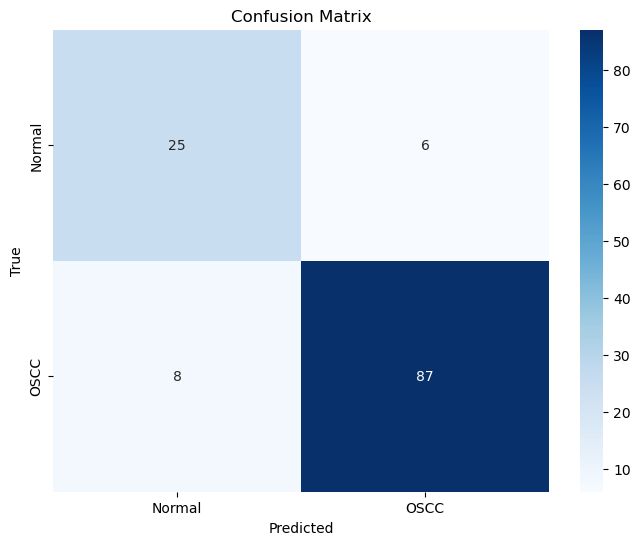

              precision    recall  f1-score   support

      Normal       0.76      0.81      0.78        31
        OSCC       0.94      0.92      0.93        95

    accuracy                           0.89       126
   macro avg       0.85      0.86      0.85       126
weighted avg       0.89      0.89      0.89       126



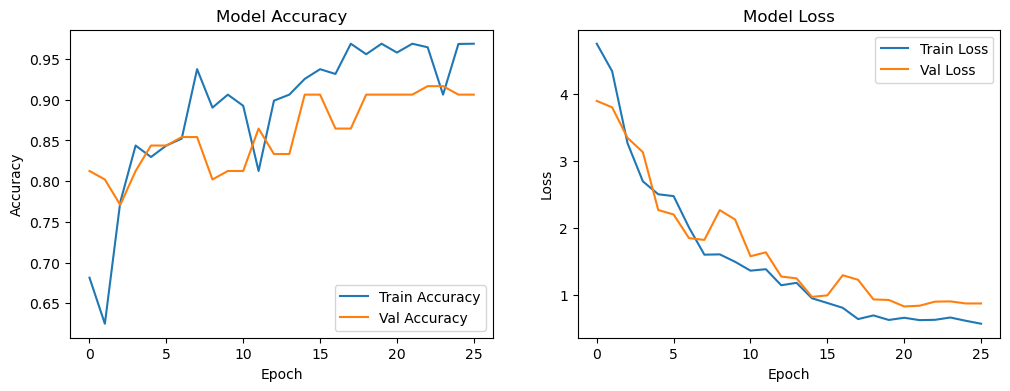

In [13]:
# Evaluate on test set
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}")

# Predictions and Confusion Matrix
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

<>:24: SyntaxWarning: invalid escape sequence '\O'
<>:24: SyntaxWarning: invalid escape sequence '\O'
C:\Users\DELL\AppData\Local\Temp\ipykernel_18420\3971080123.py:24: SyntaxWarning: invalid escape sequence '\O'
  test_image_path = "test\OSCC\OSCC_100x_113.jpg"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
Predicted Class: OSCC
Confidence: 99.99%


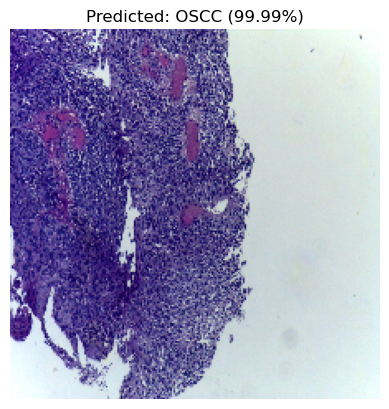

In [17]:
def predict_and_display(image_path, model, class_labels):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    confidence = predictions[0][predicted_class] * 100

    # Display result
    print(f"Predicted Class: {class_labels[predicted_class]}")
    print(f"Confidence: {confidence:.2f}%")

    # Visualize
    plt.imshow(img)
    plt.title(f"Predicted: {class_labels[predicted_class]} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

# Test on a sample image
test_image_path = "test\OSCC\OSCC_100x_113.jpg"
predict_and_display(test_image_path, model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Predicted Class: Normal
Confidence: 100.00%


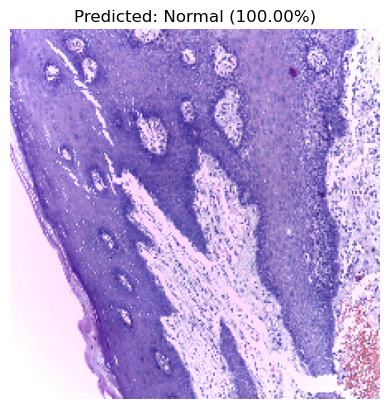

In [29]:
test_image_path = r"test\Normal\Normal_100x_2.jpg"

predict_and_display(test_image_path, model, class_labels)

In [ ]:
model.save('vgg16_final_model.h5')